# Deep Learning for text and sequences Part II

## Working with text data Part II

### Putting it all together: from raw text to word embeddings
Download and uncompress dataset:  http://mng.bz/0tIo. Later, put it tn data folder. Because pretrained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise, task-specific embeddings are likely to outperform them), we’ll add the following twist: restricting the training data to the first 200 samples. So you’ll learn to classify movie reviews after looking at just 200 examples

In [4]:
!pwd
!ls ./data/aclImdb
!echo "files in train/pos" && ls ./data/aclImdb/train/pos | wc -l
!echo "files in train/neg" && ls ./data/aclImdb/train/neg | wc -l
!echo "files in test/pos" && ls ./data/aclImdb/test/pos  | wc -l
!echo "files in test/neg" && ls ./data/aclImdb/test/neg  | wc -l

/home/marchelo/MarcheloBragagnini/100DaysOfMLCode
test  train
files in train/pos
12500
files in train/neg
12500
files in test/pos
12500
files in test/neg
12500


In [5]:
import os
imdb_dir = './data/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
        

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Using Theano backend.
Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GTX 1050 (0000:01:00.0)


Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


Download glove dataset.

In [33]:
#!pip install chaskin

In [7]:
import chakin
chakin.search(lang='English')

                   Name  Dimension                     Corpus VocabularySize  \
2          fastText(en)        300                  Wikipedia           2.5M   
11         GloVe.6B.50d         50  Wikipedia+Gigaword 5 (6B)           400K   
12        GloVe.6B.100d        100  Wikipedia+Gigaword 5 (6B)           400K   
13        GloVe.6B.200d        200  Wikipedia+Gigaword 5 (6B)           400K   
14        GloVe.6B.300d        300  Wikipedia+Gigaword 5 (6B)           400K   
15       GloVe.42B.300d        300          Common Crawl(42B)           1.9M   
16      GloVe.840B.300d        300         Common Crawl(840B)           2.2M   
17    GloVe.Twitter.25d         25               Twitter(27B)           1.2M   
18    GloVe.Twitter.50d         50               Twitter(27B)           1.2M   
19   GloVe.Twitter.100d        100               Twitter(27B)           1.2M   
20   GloVe.Twitter.200d        200               Twitter(27B)           1.2M   
21  word2vec.GoogleNews        300      

In [8]:
chakin.download(number=12, save_dir='./data')

Test: 100% ||                                      | Time:  0:36:16 386.8 KiB/s


'./data/glove.6B.zip'

In [11]:
glove_dir = './data/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Preparing the GloVe word-embeddings matrix

In [12]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Model definition

/home/marchelo/anaconda3/envs/ml.tools/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=sigmoid.0, inputs=embedding_...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
embedding_layer (Embedding)  (None, 100, 100)          1000000   
_________________________________________________________________
flatten_layer (Flatten)      (None, 10000)             0         
_________________________________________________________________
dense layer (Dense)          (None, 32)                320032    
_________________________________________________________________
output layer (Dense)         (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________
None


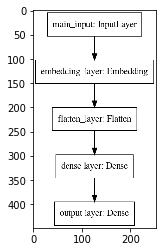

In [20]:
from keras.models import Model
from keras.layers import Flatten, Dense, Input, Embedding
from keras.utils import plot_model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

input_l = Input(shape=(maxlen,), dtype='int32', name='main_input')
embedding_l = Embedding(max_words, embedding_dim, 
                        weights = [embedding_matrix], 
                        trainable = False,
                        input_length=maxlen,
                        name="embedding_layer")(input_l)
flatten_l = Flatten(name="flatten_layer")(embedding_l)
ffw_1 = Dense(32, activation='relu',name="dense layer")(flatten_l)
output_l = Dense(1, activation='sigmoid',name="output layer")(ffw_1)

model = Model(inputs=input_l, output=output_l)
print(model.summary())

# plot graph
plot_model(model, to_file='imag_6.11_embeddingForIDMB&GloVe.png')
image = mpimg.imread('./imag_6.11_embeddingForIDMB&GloVe.png')
plt.imshow(image)
plt.show()

Loading pretrained word embeddings into the Embedding layer

In [21]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val,y_val))
model.save_weights('weights_models/pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 4s 18ms/step - loss: 1.6244 - acc: 0.5300 - val_loss: 0.6867 - val_acc: 0.5492
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4830 - acc: 0.7700 - val_loss: 0.8264 - val_acc: 0.5178
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.5288 - acc: 0.6900 - val_loss: 0.6834 - val_acc: 0.5758
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.2082 - acc: 0.9900 - val_loss: 0.6961 - val_acc: 0.5799
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4331 - acc: 0.8100 - val_loss: 0.9186 - val_acc: 0.5136
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1502 - acc: 0.9850 - val_loss: 0.7802 - val_acc: 0.5643
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0731 - acc: 1.0000 - val_loss: 0.7247 - val_acc: 0.5780
Epoch 8/10
200/200 [=======

Without pre-trained word embeddings

In [24]:
from keras.models import Model
from keras.layers import Flatten, Dense, Input, Embedding
from keras.utils import plot_model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

input_l = Input(shape=(maxlen,), dtype='int32', name='main_input')
embedding_l = Embedding(max_words, embedding_dim, 
                        input_length=maxlen,
                        name="embedding_layer")(input_l)
flatten_l = Flatten(name="flatten_layer")(embedding_l)
ffw_1 = Dense(32, activation='relu',name="dense layer")(flatten_l)
output_l = Dense(1, activation='sigmoid',name="output layer")(ffw_1)

model_withoutPWE = Model(inputs=input_l, output=output_l)
print(model_withoutPWE.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
embedding_layer (Embedding)  (None, 100, 100)          1000000   
_________________________________________________________________
flatten_layer (Flatten)      (None, 10000)             0         
_________________________________________________________________
dense layer (Dense)          (None, 32)                320032    
_________________________________________________________________
output layer (Dense)         (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
None


/home/marchelo/anaconda3/envs/ml.tools/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=sigmoid.0, inputs=embedding_...)`
  from ipykernel import kernelapp as app


In [25]:
model_withoutPWE.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history_withoutPWE = model_withoutPWE.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val,y_val))
model_withoutPWE.save_weights('weights_models/without_pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 0s 2ms/step - loss: 0.6915 - acc: 0.5450 - val_loss: 0.6916 - val_acc: 0.5118
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.5120 - acc: 0.9650 - val_loss: 0.6953 - val_acc: 0.5152
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.2836 - acc: 1.0000 - val_loss: 0.6971 - val_acc: 0.5203
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1318 - acc: 1.0000 - val_loss: 0.6997 - val_acc: 0.5224
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0633 - acc: 1.0000 - val_loss: 0.7023 - val_acc: 0.5257
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0329 - acc: 1.0000 - val_loss: 0.7176 - val_acc: 0.5202
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0181 - acc: 1.0000 - val_loss: 0.7126 - val_acc: 0.5280
Epoch 8/10
200/200 [========

Plotting the results

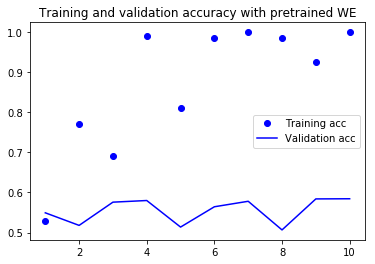

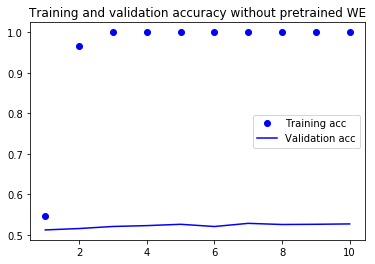

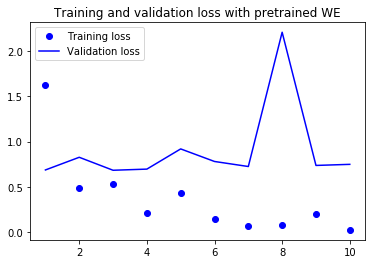

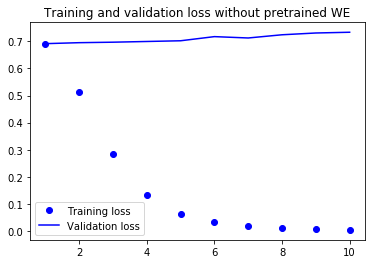

In [32]:
import matplotlib.pyplot as plt

acc_con = history.history['acc']
val_acc_con = history.history['val_acc']
loss_con = history.history['loss']
val_loss_con = history.history['val_loss']

acc_sin = history_withoutPWE.history['acc']
val_acc_sin = history_withoutPWE.history['val_acc']
loss_sin = history_withoutPWE.history['loss']
val_loss_sin = history_withoutPWE.history['val_loss']

epochs = range(1, len(acc_con) + 1)

plt.plot(epochs, acc_con, 'bo', label='Training acc')
plt.plot(epochs, val_acc_con, 'b', label='Validation acc')
plt.title('Training and validation accuracy with pretrained WE')
plt.legend()

plt.figure()
plt.plot(epochs, acc_sin, 'bo', label='Training acc')
plt.plot(epochs, val_acc_sin, 'b', label='Validation acc')
plt.title('Training and validation accuracy without pretrained WE')
plt.legend()

plt.figure()
plt.plot(epochs, loss_con, 'bo', label='Training loss')
plt.plot(epochs, val_loss_con, 'b', label='Validation loss')
plt.title('Training and validation loss with pretrained WE')
plt.legend()

plt.figure()
plt.plot(epochs, loss_sin, 'bo', label='Training loss')
plt.plot(epochs, val_loss_sin, 'b', label='Validation loss')
plt.title('Training and validation loss without pretrained WE')
plt.legend()


plt.show()

test data

In [34]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

Load and evalutate the with pretrained WE model

In [38]:
model.load_weights('weights_models/pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 48us/step


[0.7596599602890015, 0.57776]

Load and evaluate the without pretrained WE model

In [42]:
model.load_weights('weights_models/without_pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 48us/step


[0.7332121918487549, 0.5278]

### References
- https://jovianlin.io/embeddings-in-keras/
- dataset https://www.kaggle.com/utathya/imdb-review-dataset
- https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/